# Curve Fitting Uncertainties with PSL Uncertainty Calculator

This notebook demonstrates curve fitting, both linear and non-linear, using the curvefit module of the PSL uncertainty calculator. The model parameters (e.g. slope and intercept in the linear case) are fit using a least-squares regression. Uncertainties in the parameters are computed using four different methods for comparison. For a description of each method, see the `Curvefit Methods` notebook.

The `CurveFit` class takes `func` as an argument. This can be a callable Python function, a sympifyable string expression, or one of the predefined function names as follows:

- `line` - (default): $y = a + bx$
- `exp` - Exponential: $y = a exp{(x/b)} + c$
- `decay` - Exponential decay, no offset: $y = a \exp{(-x/b)}$
- `log` - Natural Log function: $y = a + b \log{(x-c)}$
- `logistic` - Logistic growth: $y = a / (1 + \exp{((x-c)/b)}) + d$
- `quad` - Quadratic Polynomial: $y = a + bx + cx^2$
- `cubic` - Cubic Polynomial: $y = a + bx + cx^2 + dx^3$
- `poly` - General Polynomial. Provide `polyorder` parameter: $y = a + bx + cx^2 ... kx^n$

Once the pamrater values and uncertainties are computed, functions for finding confidence band of the fit line and a prediction band for new measurements are also generated and plotted.

The fit values and uncertainties are found using the four methods described below for comparison.

#### Definitions:
Confidence band: Uncertainty that the fit line passes through the true mean value of the line

Prediction band: Uncertainty in taking a new measurement at a given X value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import wofz  # For the Voigt function example

import suncal
from suncal import curvefit

In [2]:
def plotit(f):
    ''' Calculate and plot comparison of fits '''
    mcmc = hasattr(f, 'mcmc')
    cols = 4 if mcmc else 3
    fig, ax = plt.subplots(ncols=cols, figsize=(14,4))
    f.gum.plot_summary(ax=ax[0])
    f.lsq.plot_summary(ax=ax[1])
    f.mc.plot_summary(ax=ax[2])
    if mcmc:
        f.mcmc.plot_summary(ax=ax[3])
        ax[3].set_title('Markov Chain MC')
    ax[0].set_title('GUM')
    ax[1].set_title('Least-Squares')
    ax[2].set_title('Monte Carlo')
    fig.tight_layout()

## Linear Fit

For a straight line, use the simplified ArrayLineFit class (a special case of the more generic ArrayCurveFit class).

$y = a + b x$


Method                    | b         | u(b)      | a         | u(a)     
-------------------------|---------|---------|---------|---------
Least Squares             | 0.547  | 0.059  | -5.2  | 1.8 
GUM Approximation         | 0.547  | 0.059  | -5.2  | 1.8 
Monte Carlo               | 0.549  | 0.060  | -5.3 | 1.8
Markov-Chain Monte Carlo  | 0.544 | 0.061 | -5.1 | 1.8

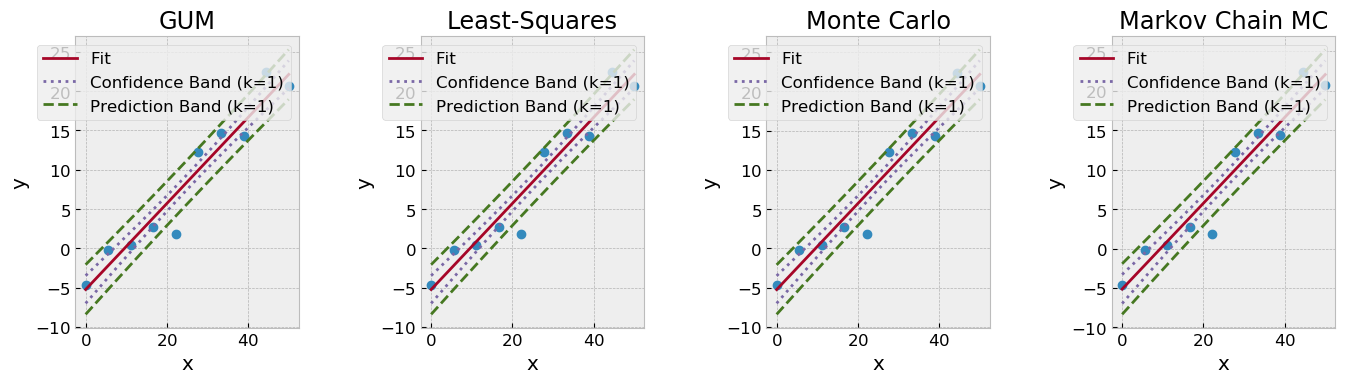

In [3]:
# Generate some data
a, b = -5, .5
uy = 3
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

# Non-linear fitting

Common functions for quadratic, cubic, polynomial, and exponential are predefined in the CurveFit class and can be used by passing a string argument ('quad', 'cubic', 'poly', or 'exp') to the CurveFit.

$y = a + b x + c x^{2}$


Method                    | a         | u(a)      | b         | u(b)      | c         | u(c)     
-------------------------|---------|---------|---------|---------|---------|---------
Least Squares             | 1.80  | 0.13  | -0.810  | 0.099  | 0.228  | 0.025 
GUM Approximation         | 1.80  | 0.13  | -0.810  | 0.098  | 0.228 | 0.025
Monte Carlo               | 1.81 | 0.13 | -0.810 | 0.099 | 0.228 | 0.025
Markov-Chain Monte Carlo  | 1.81 | 0.14 | -0.807 | 0.099 | 0.227 | 0.025

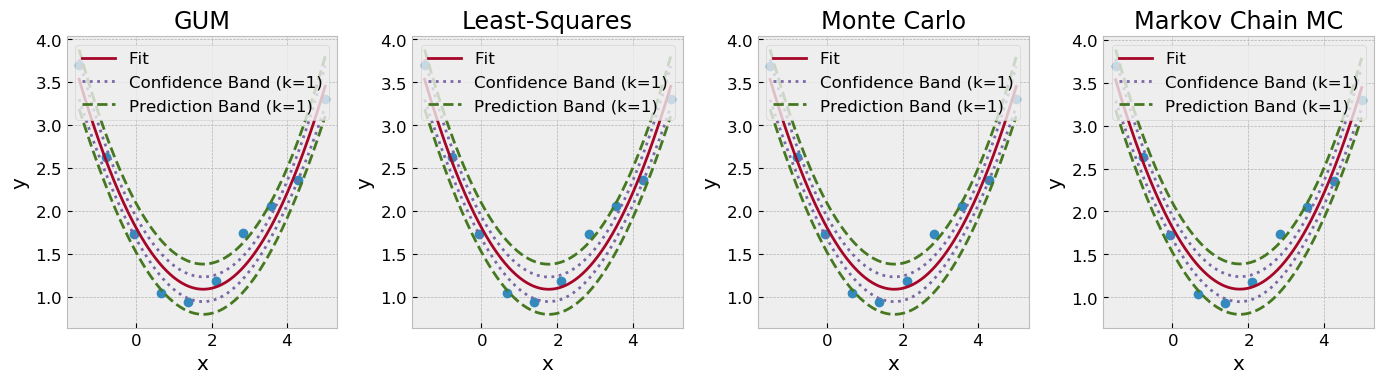

In [4]:
# Generate some quadratic data with noise
a, b, c = 2, -1, 0.25
uy = .3
x = np.linspace(-1.5, 5, num=10)
y = a + b*x + c*x*x + np.random.normal(loc=0, scale=uy, size=len(x))

# Calculate fit and uncertainty
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='quad', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

$y = a + b x + c x^{2} + d x^{3} + e x^{4}$


Method                    | a         | u(a)      | b         | u(b)      | c         | u(c)      | d         | u(d)      | e         | u(e)     
-------------------------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------
Least Squares             | 0.97  | 0.27  | 0.081  | 0.57  | -2.00  | 0.39  | -0.061  | 0.52  | -0.025  | 0.22 
GUM Approximation         | 0.97 | 0.37 | 0.081 | 0.67 | -2.00 | 0.55 | -0.061 | 0.62 | -0.025 | 0.29
Monte Carlo               | 0.97 | 0.27 | 0.081 | 0.58 | -2.00 | 0.39 | -0.064 | 0.52 | -0.028 | 0.22
Markov-Chain Monte Carlo  | 1.01 | 0.13 | 0.034 | 0.25 | -2.11 | 0.38 | 0.00044 | 0.29 | 0.025 | 0.21

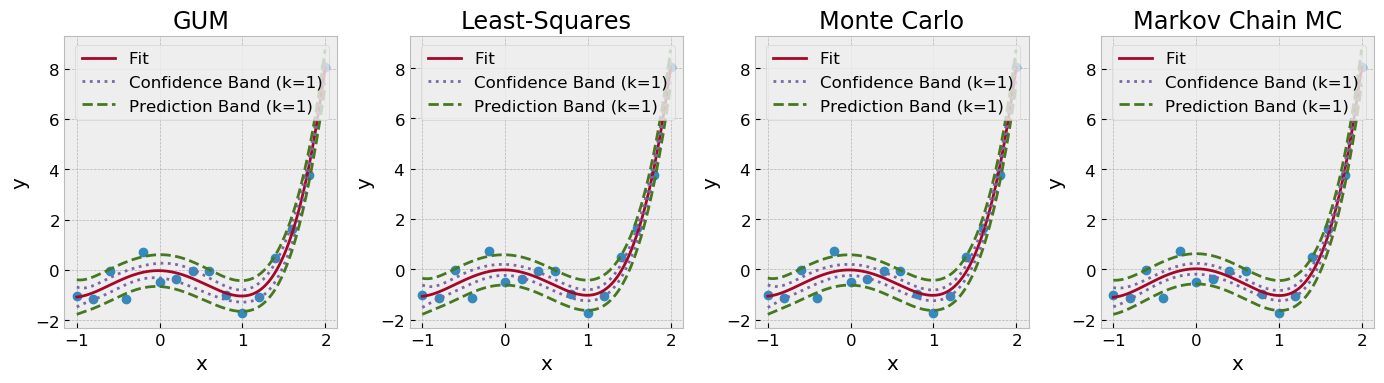

In [5]:
# Polynomial - must also specify the polyorder parameter.
uy = .5
x = np.linspace(-1, 2, num=16)
y = x**4 - 2*x**2 + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr, func='poly', polyorder=4)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

$y = a e^{\frac{x}{b}} + c$


Method                    | a         | u(a)      | b         | u(b)      | c         | u(c)     
-------------------------|---------|---------|---------|---------|---------|---------
Least Squares             | 1.018  | 0.071  | -2.20  | 0.37  | 4.997  | 0.041 
GUM Approximation         | 1.018  | 0.073  | -2.20  | 0.56  | 4.997 | 0.057
Monte Carlo               | 1.029 | 0.070 | -2.29 | 0.56 | 4.988 | 0.054
Markov-Chain Monte Carlo  | 1.021 | 0.072 | -2.33 | 0.42 | 4.986 | 0.044

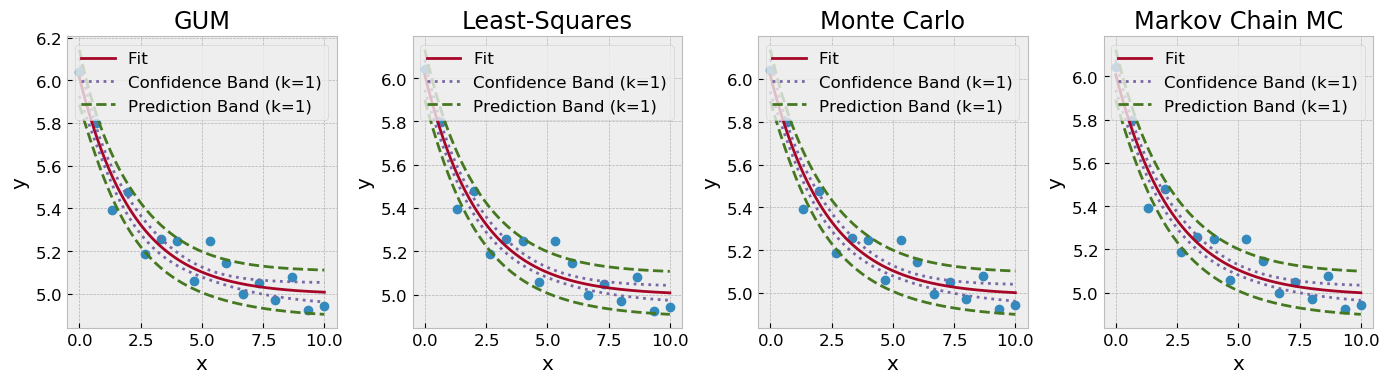

In [6]:
# Exponential
a, b = 2, 5
uy = .08
x = np.linspace(0, 10, num=16)
y = np.exp(-x/a) + b + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp', arr=arr, p0=(1, -2, 5))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

$y = e^{- \frac{x}{b}}$


Method                    | b         | u(b)     
-------------------------|---------|---------
Least Squares             | 2.18  | 0.15 
GUM Approximation         | 2.18  | 0.14 
Monte Carlo               | 2.18  | 0.15 
Markov-Chain Monte Carlo  | 2.19  | 0.14

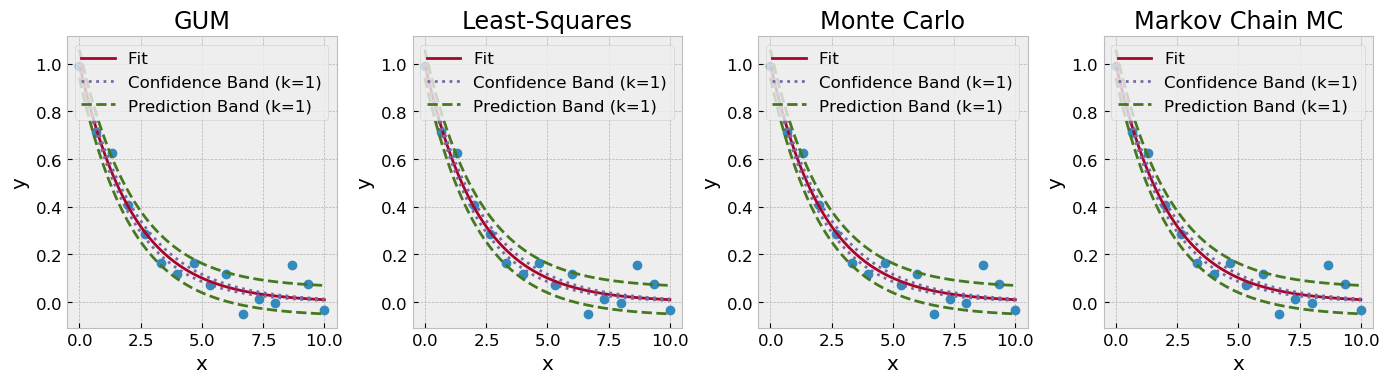

In [7]:
# Exponential, custom-defined as string expression with only one parameter
b = 2
uy = .06
x = np.linspace(0, 10, num=16)
y = np.exp(-x/b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp(-x/b)', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

$y = f{\left (x,a,b \right )}$


Method                    | a         | u(a)      | b         | u(b)     
-------------------------|---------|---------|---------|---------
Least Squares             | 144.95  | 0.34  | 20.04  | 0.28 
GUM Approximation         | 144.95  | 0.34  | 20.04  | 0.28 
Monte Carlo               | 144.95  | 0.35  | 20.04 | 0.27
Markov-Chain Monte Carlo  | 144.93 | 0.34 | 20.04 | 0.29

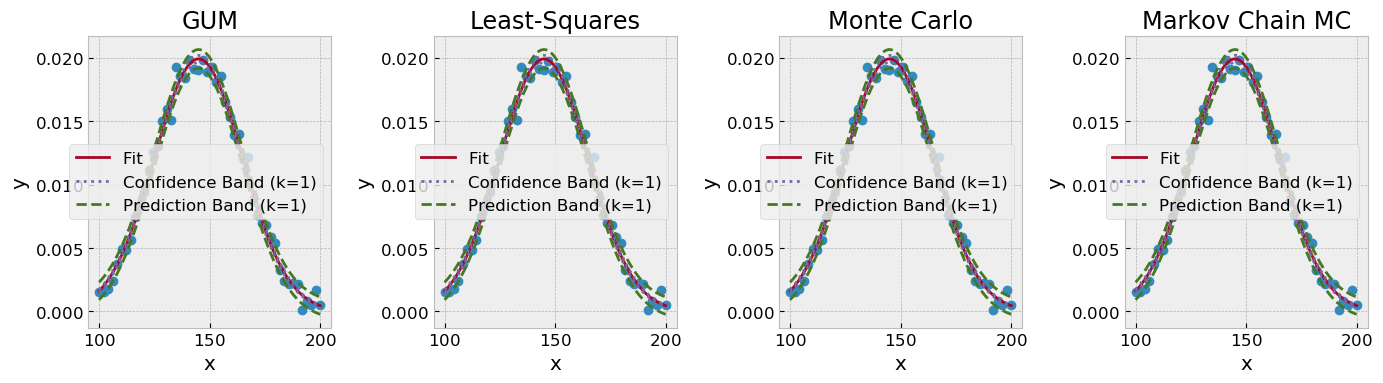

In [8]:
# Normal function - This one needs an initial guess to converge
def func(x, a, b):
    return stats.norm.pdf(x, loc=a, scale=b)

a, b = 145, 20
uy = .001
x = np.linspace(100, 200, 50)
y = func(x, a, b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, b))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

$y = f{\left (x,a,p,z \right )}$


Method                    | a         | u(a)      | p         | u(p)      | z         | u(z)     
-------------------------|---------|---------|---------|---------|---------|---------
Least Squares             | 3.002  | 0.099  | 0.3951  | 0.0030  | 1.022  | 0.071 
GUM Approximation         | 3.002  | 0.099  | 0.3951  | 0.0030  | 1.022 | 0.071
Monte Carlo               | 3.01 | 0.10 | 0.3951 | 0.0030 | 1.021 | 0.070
Markov-Chain Monte Carlo  | 3.00 | 0.100 | 0.3952 | 0.0030 | 1.022 | 0.072

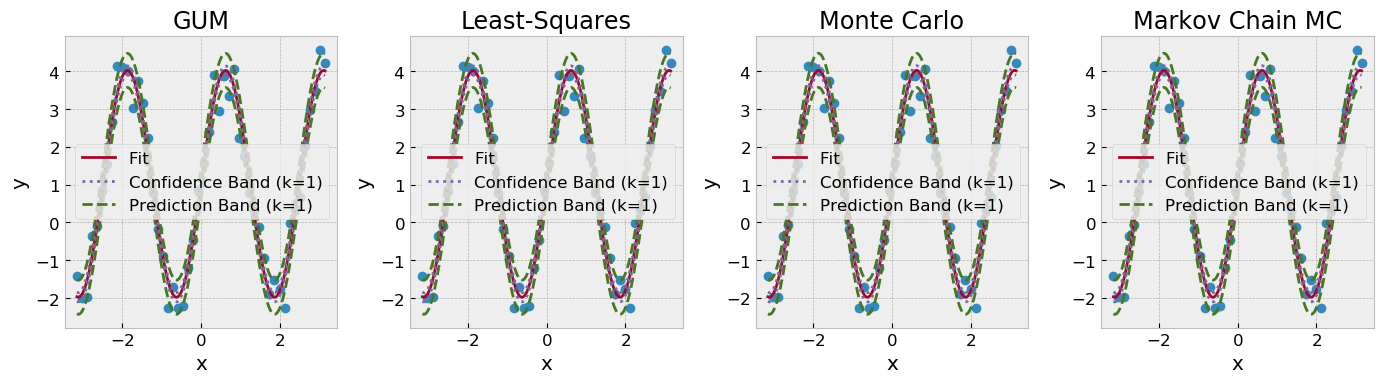

In [9]:
# sine function - Interestingly, MC needs an initial guess, but the others converge without.
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

/Users/cjdelke/miniconda3/envs/uncertosx/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in true_divide
  
/Users/cjdelke/Code/PSLUncertaintyCalc/suncal/curvefit.py:477: RuntimeWarning: overflow encountered in square
  problognew = -1/(2*sig2) * sum((self.arr.y - Ynew)**2)


$y = f{\left (x,\left|{gam}\right|,gammaL,center,base,area \right )}$


Method                    | gammaG    | u(gammaG)   | gammaL    | u(gammaL)   | center    | u(center)   | base      | u(base)   | area      | u(area)  
-------------------------|---------|-----------|---------|-----------|---------|-----------|---------|---------|---------|---------
Least Squares             | 1.49  | 0.58    | 1.78  | 0.53    | 520.06  | 0.11    | 0.0026  | 0.0017  | 0.841  | 0.082 
GUM Approximation         | 1.5 | 1.2   | 1.8 | 1.2   | 520.06 | 0.11   | 0.0026 | 0.0026 | 0.84 | 0.16
Monte Carlo               | 1.44 | 0.60   | 1.72 | 0.65   | 520.06 | 0.11   | 0.0026 | 0.0017 | 0.839 | 0.082
Markov-Chain Monte Carlo  | 1.71 | 0.60   | 1.49 | 0.66   | 520.06 | 0.11   | 0.0021 | 0.0018 | 0.872 | 0.086

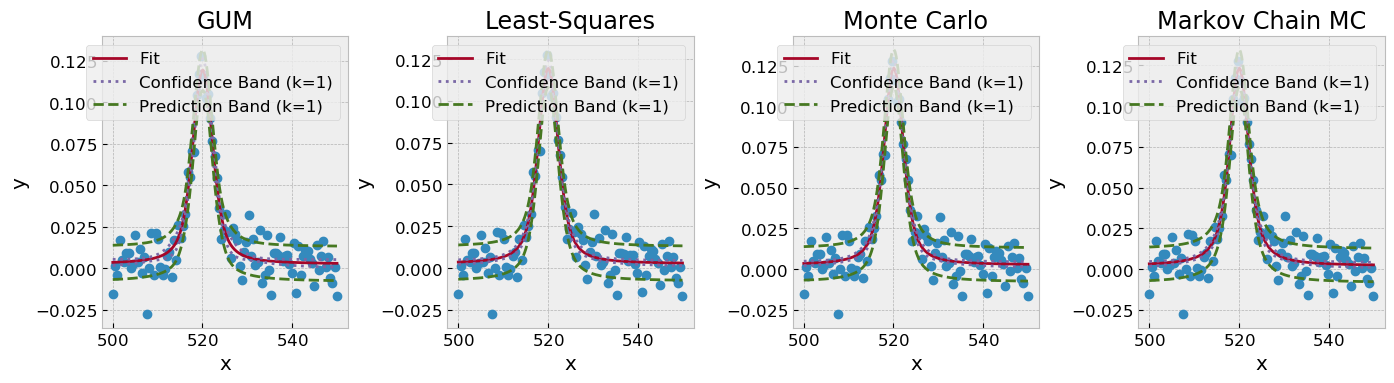

In [10]:
# Voigt function (used in Raman spectroscopy) 
# This is a case where GUM uncertainties don't match other methods.
def func(x, gammaG, gammaL, center, base, area):
    ''' Voigt function, shifted/scaled. '''
    sigma = gammaL / np.sqrt(2 * np.log(2))
    vv = np.real(wofz((x-center + 1j*gammaG)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    vv = area*vv
    vv += base
    return vv

args = [2, 1.8, 520, 0, 1]
x = np.linspace(500, 550, 100)
uy = .01
y = func(x, *args) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=args)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

## Uncertainty in X values

The same tests can be repated with uncertainties in the X values. In this case, the curve fit will use orthogonal distance regression, or the York method if the model is linear. Compared to the ux=0 examples above, the uncertainty should be a bit higher for each parameter.

Note the Markov-Chain Monte Carlo method does not currently incorporte uncertainty in X values. Add the `mcmc=True` parameter to the `calculate()` method to see the discrepancy in results.

$y = a + b x$


Method             | b         | u(b)      | a         | u(a)     
------------------|---------|---------|---------|---------
Least Squares      | 0.502  | 0.064  | -4.4  | 1.9 
GUM Approximation  | 0.493  | 0.065  | -4.2  | 1.9 
Monte Carlo        | 0.487  | 0.065  | -4.0 | 1.9

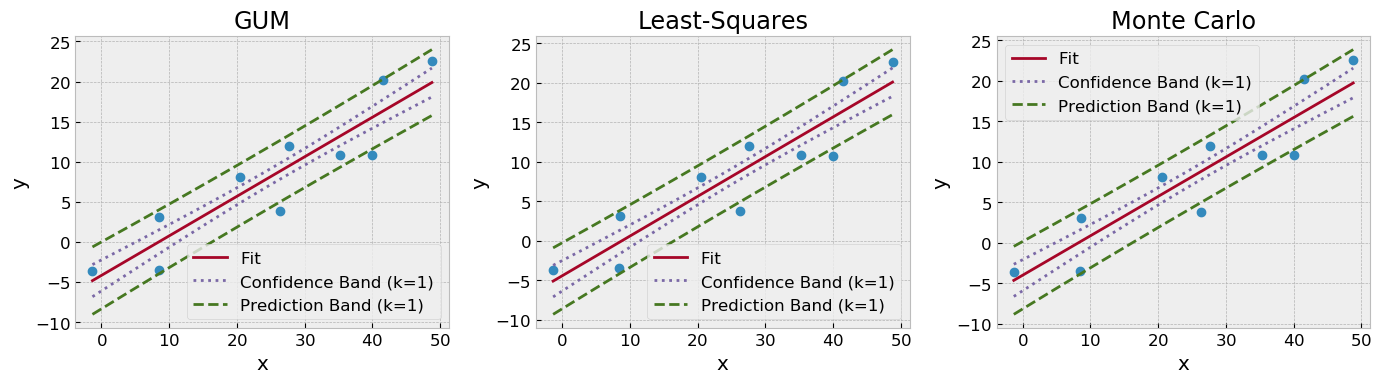

In [11]:
# Generate linear data with uncertainty in x and y
a, b = -5, .5
uy = 3
ux = 2
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(arr, p0=[-5, 0.5])
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)

Warning - ODR failed to converge


$y = f{\left (x,a,p,z \right )}$


Method             | a         | u(a)      | p         | u(p)      | z         | u(z)     
------------------|---------|---------|---------|---------|---------|---------
Least Squares      | 3.94  | 0.27  | 0.3834  | 0.0064  | 0.74  | 0.21 
GUM Approximation  | 3.09  | 0.23  | 0.3875  | 0.0082  | 0.58 | 0.19
Monte Carlo        | 2.67 | 0.21 | 0.3910 | 0.0082 | 0.69 | 0.15

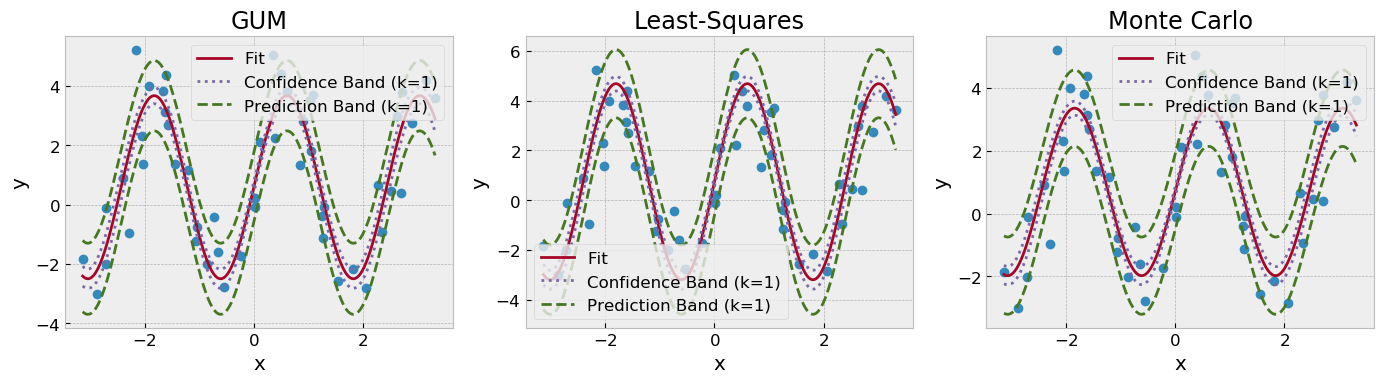

In [12]:
# sine function with uncertainty in x and y
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
ux = .2
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)